# Analysis on predictive models for daily stock volume


In [270]:
# setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from datetime import datetime, timedelta

from ipywidgets import IntProgress
from IPython.display import Markdown as md, display, Math, Latex
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn import metrics

# NOTE - modify when pkg destination changed
from models.volume.core import ADV, MDV

_RUN_DATE = datetime.utcnow().date()
_VOLUME_FILE = "/home/cnoble/Documents/market_data/volume/snp_500_2022-08-29-20-Y.csv"
_YEAR_DAYS = 365.24

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.max_colwidth", None)

# load, fix and split data

volume = pd.read_csv(_VOLUME_FILE).set_index("date")
volume.index = pd.to_datetime(volume.index)

# fix zero volumes
volume = volume.replace(0.0, np.nan)

# remove partial day
volume = volume[volume.index != "2022-08-29"]

# filter lookback
end_date = datetime(2020, 8, 29)
data_lookback = timedelta(days= 10 * _YEAR_DAYS)
volume = volume[volume.index >= (end_date - data_lookback)]

# train / test split
train_volume, test_volume = train_test_split(volume, test_size=0.1, shuffle=False)

## Abstract

The goal of this analysis is to reproduce the *ARMA daily forecasting model* presented in Algorithmic Trading Methods - Kissel and compare it's performance against the standard ADV30 measure for predicting daily volumes.

## Lexicon

$ADV(n)$: Average Daily Volume of $n$ day rolling window

$MDV(n)$: Median Daily Volume of $n$ day rolling window

## Analysis goals

1. Calculate $ADV(n)$ and $MDV(n)$ across a range of horizon hyperparameters. Evaluate predictive performance and select the best for:

    a. A baseline predictor for daily volume
    
    b. Input variable for ARMA model
    
2. Discuss ARMA model and input variables

3. Fit and compare ARMA model to 'best' simplistic baseline from Step 1.

## Data
    
### Universe
    
S&P 500 stocks (as of {_RUN_DATE})

### Daily volumes
    
10 years (as of {_RUN_DATE}) look back of daily consolidated volumes obtained from the Interactive Brokers TWS API. Consolidated volume is extracted from the 'SMART' exchange provided by IB, this is effectively all volume available to the IB smart order router and is (according to IB) their best available volume measure.

**Note: No trading phases are resolved and it is assumed that the daily measures include auction volume**)

**Note: All data (with full window to support lagged metrics) are included**

### Train/Test split

1. 80/20% split will be used when fitting the ARMA model and evaluating test performance
2. We do not shuffle data between splits. We expect market behaviour changes over time and want test performance to reflect the current market

**TODO: Lagged variables spill over from train into test data... is this OK?**
**TODO: how to improve / analyze shifts in market behaviour?**
        

## Step 1: ADV and MDV analysis

1. Calculating $ADV(n)$, $MDV(n)$ for $n \in [1:50]$
2. Compute percentage error for each metric and view mean and std-dev percentage error for each stock
3. Select appropriate metric base on the error profiles

**NOTE: We use standard percentage error calculation not log ratio... Log derived percentage error is only valid for small deviations and we expect volume estimate errors to be large here, >> %5 (the point at which ln(Vt/Vt-1) diverges from ((Vt - Vt-1) / Vt-1). As a result we do not make any adjustments for the effect of volume / mkt cap as discussed in the text** 

In [247]:

max_window = 30

results = list()
f = IntProgress(min=0, max=max_window-1) # instantiate the bar
display(f)

for window in range(1, max_window):

    # calculate ADV and MDV for window
    adv = ADV(train_volume, window)
    mdv = MDV(train_volume, window)

    # calculate %ge error
    # TODO - is ln(adv / vol) valid given large deviations?
    # TODO - think of different way to normalize affect of volume across stocks.
    
    # adv_err = np.log(adv / volume)
    # mdv_err = np.log(mdv / volume)   
    adv_err = (adv - volume) / volume
    mdv_err = (mdv - volume) / volume
    
    # calculate stock level first and second moments, then average over stocks
    adv_mean_err = adv_err.mean().mean()
    adv_std_err = adv_err.std().mean()
    mdv_mean_err = mdv_err.mean().mean()
    mdv_std_err = mdv_err.std().mean()
    

    results.append([window, adv_mean_err, adv_std_err, mdv_mean_err, mdv_std_err])

    f.value += 1
    
err = pd.DataFrame(results, columns=["window", "adv_mu", "adv_sig", "mdv_mu", "mdv_sig"])

IntProgress(value=0, max=29)

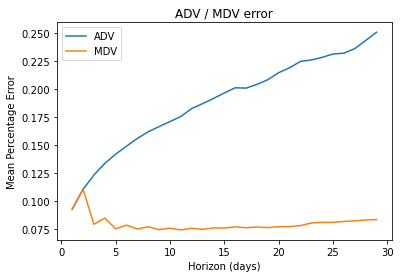

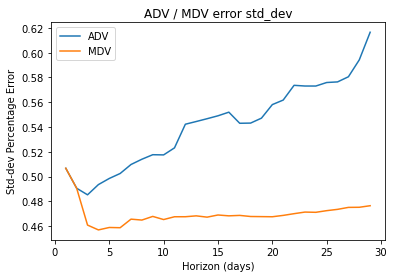

In [248]:
# Plot error for ADV and MDV metrics over the horizons

plt.plot(err["window"], err[["adv_mu", "mdv_mu"]])
plt.title("ADV / MDV error")
plt.xlabel("Horizon (days)")
plt.ylabel("Mean Percentage Error")
plt.legend(["ADV", "MDV"])
plt.show()

plt.plot(err["window"], err[["adv_sig", "mdv_sig"]])
plt.title("ADV / MDV error std_dev")
plt.xlabel("Horizon (days)")
plt.ylabel("Std-dev Percentage Error")
plt.legend(["ADV", "MDV"])
plt.show()

## Analysis

1. We can see that MDV average error appears hit a minimum between 5-15 day horizon (at ~7%) then starts to slowly diverge to converge. ADV diverges aggressively with increasing horizon, likely this is due to outliers adversely affecting ADV (longer horizon's increase likelihood window contains an outlier).
2. The std-dev error hits it's minimum MDV at around 5 days (at ~47%). ADV std-dev error diverges more aggressively but with a similar minimum for horizon

This simple analysis supports use of $MDV(5)$ as a reasonable statistic for use in steps 2 & 3

## Step 2: ARMA model

The ARMA model is defined as:

$\hat{V}_t = \bar{V}_{t-1} . D_t + \hat{\beta} . e_{t-1}$

Where:

$\hat{V}_t$ = forecast volume on day t

$\bar{V}_{t-1}$ = $MDV(5)$ selected base volume metric from Step 1.

$D_w$ = day of week adjustment metric

$e_{t-1}$ = Previous days forecast error ($V_{t-1} - \hat{V}_{t-1}$)

$\hat{\beta}$ = Auto-regressive sensitivity parameter - esimated by OLS regression

Rationale is as follows:

1. We use a stable measure of contemporary historical volume $MDV(5)$ on which to base our estimate
2. We believe weekly trade volume is cyclical (weekly) thus add another variable here to adjust $MDV(5)$ on this basis
2. We add an auto-regressive term to capture persistent excess volume across days


### Calculating $D_w$

Our goal here is to determine what (if any) cyclical relationships there are across weekdays.

1. Calculate the deviation of daily trading volumes from their (lagged) weekly average across stocks
2. Average across stocks for each day

We see that there is a hump mid-week with the lowest volume day being Monday. This profile reflects the comments in the text discussing the dip in volume on Friday (one that was not present further back in time).

In [249]:
# calculate cyclical week day volumes (use training set)
# TODO - could use full data set here?

calendar = pd.to_datetime(train_volume.index).isocalendar()
week_keys = calendar.year * 100 + calendar.week

date_week = train_volume.copy()
date_week["week_key"] = week_keys
date_week = date_week["week_key"].reset_index()

week_volume = train_volume.copy()
week_volume["week_key"] = week_keys
week_volume = week_volume.groupby("week_key", as_index=False).mean()
week_volume = date_week.merge(week_volume, how="left", left_on="week_key", right_on="week_key").set_index("date").drop("week_key", axis=1)

pct_volume = train_volume / week_volume
weekday_pct_volume = pct_volume.groupby([calendar.day]).mean().mean(axis=1)

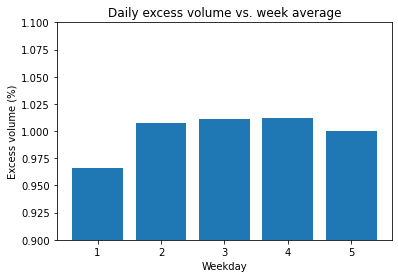

In [250]:
plt.bar(weekday_pct_volume.index, weekday_pct_volume.values)
plt.ylim([0.9, 1.1])
plt.title("Daily excess volume vs. week average") 
plt.ylabel("Excess volume (%)")
plt.xlabel("Weekday")
plt.show()

## Fit the ARMA model

The next step was to fit the auto-regressive coefficient $\hat{\beta}$. Initial scatter plots suggest a log-linear relationship between lagged errors (relationship to heteroskedasticity). As such I preceded by fitting the following linear model

$ln(e_t) = \alpha + \beta . ln(e_{t-1})$

where

$e_t = \hat{V}_t - \bar{V}_{t-1} . D_w$

In [293]:

def adj_mdv(vol: pd.DataFrame, wd_pct_volume: pd.Series) -> pd.DataFrame():
    """
    Prepare adjusted MDV
    """
    mdv_5 = MDV(vol, 5)
    weekdays = pd.DataFrame(index=mdv_5.index, data={"weekday":mdv_5.index.isocalendar().day})
    mdv_5 = mdv_5.join(weekdays.astype(int))
    mdv_5["weekday"] = mdv_5["weekday"].replace(wd_pct_volume)
    mdv_5 = mdv_5.rename(columns={"weekday": "D_w"})
    adj_mdv_5 = mdv_5.multiply(mdv_5["D_w"], axis=0).drop("D_w", axis=1)
    return adj_mdv_5


# regress_volume = train_volume.copy()

# # calculate inputs
# mdv_5 = MDV(regress_volume, 5)
# weekdays = pd.DataFrame(index=mdv_5.index, data={"weekday":mdv_5.index.isocalendar().day})
# mdv_5 = mdv_5.join(weekdays.astype(int))
# mdv_5["weekday"] = mdv_5["weekday"].replace(weekday_pct_volume)
# mdv_5 = mdv_5.rename(columns={"weekday": "D_w"})

# calculate errors
# adj_mdv_5 = mdv_5.multiply(mdv_5["D_w"], axis=0).drop("D_w", axis=1)
train_adj_mdv_5 = adj_mdv(train_volume, weekday_pct_volume)
train_errs = regress_volume - adj_mdv_5
train_errs_lag = train_errs.shift()

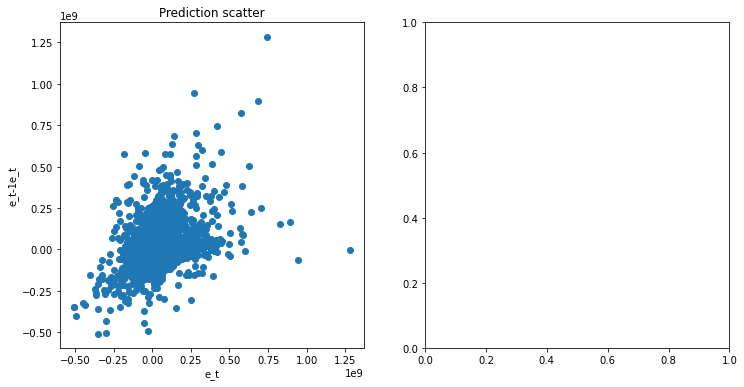

In [297]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(train_errs, train_errs_lag)
ax1.set_title("Prediction scatter")
ax1.set_ylabel("e_t-1")
ax1.set_xlabel("e_t")

# ax2.scatter(np.log(train_errs), np.log(train_errs_lag))
# ax2.set_title("Log prediction scatter")
# ax2.set_ylabel("ln(MDV_t-1(5) * D_w)")
# ax2.set_xlabel("ln(V_t)")

plt.show()

We have high in sample coefficient of determiniation $R^2$ = 0.903749504123696, alpha=154096.79437865826, beta=0.41264002608304046

[-507508931.66364765, 1282065083.9659574]
[-209264402.0046849, 529185466.48224676]


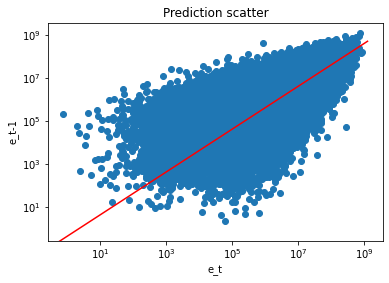

In [325]:
# fit the model

# train_adj_mdv_5_vals = train_adj_mdv_5.to_numpy().flatten()
# train_volume_vals = train_volume.to_numpy().flatten()

# nan_mask = ~(np.isnan(train_adj_mdv_5_vals) | np.isnan(train_volume_vals))

# log_train_adj_mdv_5_vals = np.log(train_adj_mdv_5_vals[nan_mask].reshape(-1, 1))
# log_train_volume_vals = np.log(train_volume_vals[nan_mask].reshape(-1, 1))

# model = LinearRegression()
# model.fit(log_train_adj_mdv_5_vals, log_train_volume_vals)
# train_r_2 = model.score(log_train_adj_mdv_5_vals, log_train_volume_vals)

# display(md(f"We have high in sample coefficient of determiniation $R^2$ = {r_2}"))

train_err_vals = train_errs.to_numpy().flatten()
train_err_lag_vals = train_errs_lag.to_numpy().flatten()

nan_mask = ~(np.isnan(train_err_vals) | np.isnan(train_err_lag_vals))

train_err_vals = train_err_vals[nan_mask].reshape(-1, 1)
train_err_lag_vals = train_err_lag_vals[nan_mask].reshape(-1, 1)

# train_err_vals = np.log(train_err_vals)
# train_err_lag_vals = np.log(train_err_lag_vals)

model = LinearRegression()
model.fit(train_err_lag_vals, train_err_vals)
train_r_2 = model.score(train_err_lag_vals, train_err_vals)

alpha = model.intercept_[0]
beta = model.coef_[0][0]

display(md(f"We have high in sample coefficient of determiniation $R^2$ = {r_2}, alpha={alpha}, beta={beta}"))


plt.scatter(train_errs, train_errs_lag)
plt.title("Prediction scatter")
plt.ylabel("e_t-1")
plt.xlabel("e_t")
plt.yscale("log")
plt.xscale("log")
pred_x = [train_errs.min().min(), train_errs.max().max()]
print(pred_x)

pred_y = [alpha + x * beta for x in pred_x]

print(pred_y)
plt.plot(pred_x, pred_y, '-r', label='y=2x+1')

# ax2.scatter(np.log(train_errs), np.log(train_errs_lag))
# ax2.set_title("Log prediction scatter")
# ax2.set_ylabel("ln(MDV_t-1(5) * D_w)")
# ax2.set_xlabel("ln(V_t)")

plt.show()


## Out of sample 

/tmp/ipykernel_162080/121750294.py:17: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(pct_err), bins=50, log=True)


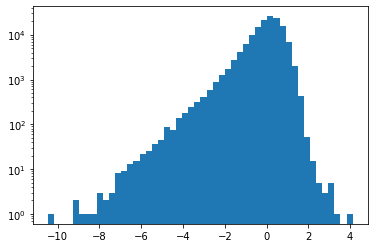

/home/cnoble/mambaforge/envs/tca/lib/python3.8/site-packages/numpy/core/function_base.py:277: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


ValueError: x and y must have same first dimension, but have shapes (10,) and (1, 10)

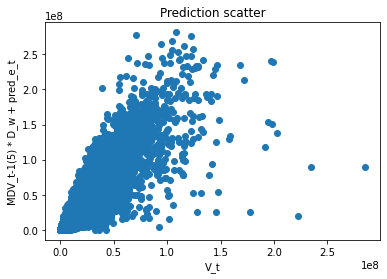

In [289]:
test_adj_mdv_5 = adj_mdv(test_volume, weekday_pct_volume)
test_adj_mdv_5_vals = test_adj_mdv_5.to_numpy().flatten()
test_volume_vals = test_volume.to_numpy().flatten()

nan_mask = ~(np.isnan(test_adj_mdv_5_vals) | np.isnan(test_volume_vals))

test_adj_mdv_5_vals = test_adj_mdv_5_vals[nan_mask]
test_volume_vals = test_volume_vals[nan_mask]

log_err_pred = model.predict(np.log(test_adj_mdv_5_vals.reshape(-1, 1))).flatten()

y_pred = test_adj_mdv_5_vals + np.exp(log_err_pred)
y_true = test_volume_vals

pct_err = (y_pred - y_true) / y_true

plt.hist(np.log(pct_err), bins=50, log=True)
plt.show()

# TODO - overflow on some predictions... FIX



plt.scatter(y_true, y_pred)
plt.title("Prediction scatter")
plt.ylabel("MDV_t-1(5) * D_w + pred_e_t")
plt.xlabel("V_t")

x = np.logspace(0,max(test_volume_vals),10)
y = model.coef_*x + model.intercept_
plt.plot(x, y, '-r', label='fit')


plt.show()

# analysis stats
# Regression metrics
explained_variance=metrics.explained_variance_score(y_true, y_pred)
mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
mse=metrics.mean_squared_error(y_true, y_pred) 
mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
r2=metrics.r2_score(y_true, y_pred)

print('explained_variance: ', round(explained_variance,4))    
print('mean_squared_log_error: ', round(mean_squared_log_error,4))
print('r2: ', round(r2,4))
print('MAE: ', round(mean_absolute_error,4))
print('MSE: ', round(mse,4))
print('RMSE: ', round(np.sqrt(mse),4))



# Discuss regression metrics / coeffs

# Analyse regression / performance metrics vs. ADV30, MDV25 
# Outlier investigation - further work on triple witching etc.

## Environment

In [ ]:
text=f"""
### UTC date:[{datetime.utcnow()}]
### Conda environment:[POPULATE!]
"""

In [ ]:
# TODO

## 1. Analyze different date ranges